<a href="https://colab.research.google.com/github/alinemls/datasets/blob/main/Iris_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de Bibliotecas

In [435]:
import numpy as np
import pandas as pd 
import seaborn as sns
import warnings
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import randint
from mlxtend.plotting import plot_confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, cohen_kappa_score as kappa, confusion_matrix
from numpy.core.numeric import NaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.tree import DecisionTreeClassifier as tree

warnings.filterwarnings("ignore")

# <><><><><><><><> Parâmetros <><><><><><><><>
p_normalizacao = 0  # 0(não normalizado), 1(desvio padrão), 2(escala 0 a 1)

t_discre = "uniform"
#‘uniform’: All bins in each feature have identical widths.
#‘quantile’: All bins in each feature have the same number of points.
#‘kmeans’: Values in each bin have the same nearest center of a 1D k-means cluster.

v_variation = 0.15

num_grupos = 3      # 0(pela classe)

qtd_faixas = 5      # 0(automático) 

n_base = "iris"

#t_sel_att = "Regressao MLP"
# Regressao MLP
# Classificador MLP
# Mutual Info

#qtd_teste = 0.3 # Porcentagem de dados para teste no seletor de atributos supervisionado

##Preparação e Carregamento das bases

In [436]:
scaler = StandardScaler()
trans = MinMaxScaler()

if n_base == "iris":
  df = sns.load_dataset(n_base)

if n_base == 'seeds':
  df = pd.read_csv("/content/drive/MyDrive/bases/seeds.csv",sep=",")

if n_base == 'glass':
  df = pd.read_csv("/content/drive/MyDrive/bases/glass.csv",sep=",")

if n_base == 'wine':
  df = pd.read_csv("/content/drive/MyDrive/bases/wine.csv",sep=",")

if n_base == 'cancer_mama':
  df = pd.read_csv("/content/drive/MyDrive/bases/cancermama.csv",sep=",")
  df = bb.iloc[: , :-1]
  col_list = list(df)
  columns_titles = ['id', 'fractal_dimension_worst', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'diagnosis']
  df=df.reindex(columns=columns_titles)


#pin = sns.load_dataset('penguins')
#iris.head()
#pin.head()
#pin.tail()
base_original = bb
print("=========> Base Original <=========\n",base_original)

#print("Descrição dos Dados:\n", base_original.describe())

# --> Remove nulls <--
data = base_original.dropna()
data = data.reset_index(drop = True)


if(num_grupos == 0): #<><><><><> Se a classe for o grupo <><><><><><>
  #print(data.columns[-1])
  #data[data.columns[-1]] = data[data.columns[-1]].map({0:'X'}, na_action='ignore')
  data[data.columns[-1]].replace(0, 'X', inplace = True)
  att_classe = data.iloc[: , -1]
  att_classe = att_classe.unique()
  qtd_classes = 0
  for item in att_classe:
    #print(item,i)
    #data.replace(to_replace=item, value=str(i))
    #data["species"].replace("setosa","kjkj", regex=True)
    data[data.columns[-1]].replace({item: qtd_classes}, inplace=True)
    qtd_classes = qtd_classes + 1
  data.columns = [*data.columns[:-1], 'grupo']
else:
  # --> Apagar Colunas classe <--
  if num_grupos > 0:
    #att_classe = "species"
    data = data.iloc[: , :-1] # Apaga o atributo classe (última coluna)


# Apaga o atributo ID
if 'ID' in data.columns:    
  data = data.drop(columns=["ID"]) 
if 'id' in data.columns: 
  data = data.drop(columns=["id"]) 

base_original = data

# --> Normalização <--
colunas = list(data.columns.values)
#print (colunas) 
n_normalizacao = "Sem Normalização"
if(p_normalizacao == 1):
  data = scaler.fit_transform(data)
  n_normalizacao = "Desvio Padrão"
if(p_normalizacao == 2):
  data = trans.fit_transform(data)
  n_normalizacao = "Escala 0-1"

data = pd.DataFrame(data, columns = colunas)

print("\n\n\n")
print("=========> Base Modificada <=========\n",data)
#print("Descrição dos Dados:\n", data.describe())


=========> Base Original <=========
      sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]




=========> Base Modificada <=========
      sepal_length  sepal_width  petal_length  petal_width
0         

In [437]:
#df = pd.read_csv('https://raw.githubusercontent.com/webalysson/datasets/main/Iris.csv')
#df.head(5)

In [438]:
df.drop(labels=['Id'], axis=1, inplace=True, errors='ignore')

In [439]:
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [440]:
# Agrupamento pela identificação completa da planta
df.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

##Agrupamento com o K-Means

In [441]:
if(num_grupos != 0): #<><><><><> Se a classe for o grupo <><><><><><>

  grupos = KMeans(num_grupos, random_state=0).fit(data)

  data = base_original

  data['grupo'] = grupos.labels_ # Cria uma coluna com o grupo de cada registro
  print("====> Base com Grupos <====\n\n",data)

print('Quantidade de Registros em cada Grupo:\n', data['grupo'].value_counts())

====> Base com Grupos <====

      sepal_length  sepal_width  petal_length  petal_width  grupo
0             5.1          3.5           1.4          0.2      1
1             4.9          3.0           1.4          0.2      1
2             4.7          3.2           1.3          0.2      1
3             4.6          3.1           1.5          0.2      1
4             5.0          3.6           1.4          0.2      1
..            ...          ...           ...          ...    ...
145           6.7          3.0           5.2          2.3      2
146           6.3          2.5           5.0          1.9      0
147           6.5          3.0           5.2          2.0      2
148           6.2          3.4           5.4          2.3      2
149           5.9          3.0           5.1          1.8      0

[150 rows x 5 columns]
Quantidade de Registros em cada Grupo:
 0    62
1    50
2    38
Name: grupo, dtype: int64


### Contrução do Modelo

In [442]:
# definir qual dataset será usado
dataset_model = df.copy()

In [443]:
X = dataset_model.drop(columns=['species']).values

In [444]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [445]:
# Transformação do atributo categórico em numérico
le = preprocessing.LabelEncoder()
le.fit(dataset_model.species)
y = le.transform(dataset_model['species'].values)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [446]:
#unique, counts = np.unique(y, return_counts=True)
#dict(zip(unique, counts))

In [447]:
# Dividindo o dataset em subconjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [448]:
print('X_train =>',X_train.shape)
print('X_test =>',X_test.shape)
print('Y_train =>',y_train.shape)
print('Y_test =>',y_test.shape)

X_train => (105, 4)
X_test => (45, 4)
Y_train => (105,)
Y_test => (45,)


In [449]:
# Modelo com DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(criterion='entropy')
clf_dt = clf_dt.fit(X_train, y_train)
y_predict_train = clf_dt.predict(X_train)
y_predict_test = clf_dt.predict(X_test)

In [450]:
X_test

array([[5. , 3.3, 1.4, 0.2],
       [7. , 3.2, 4.7, 1.4],
       [6.5, 3. , 5.5, 1.8],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.5, 1.4, 0.2],
       [4.6, 3.4, 1.4, 0.3],
       [6.6, 2.9, 4.6, 1.3],
       [6.4, 2.7, 5.3, 1.9],
       [5. , 3.5, 1.6, 0.6],
       [5.5, 2.3, 4. , 1.3],
       [7.2, 3.6, 6.1, 2.5],
       [5.8, 2.7, 5.1, 1.9],
       [6.2, 2.8, 4.8, 1.8],
       [4.3, 3. , 1.1, 0.1],
       [6.7, 3. , 5.2, 2.3],
       [5.2, 3.4, 1.4, 0.2],
       [6.5, 3. , 5.8, 2.2],
       [5.5, 2.5, 4. , 1.3],
       [5.8, 2.8, 5.1, 2.4],
       [4.8, 3.1, 1.6, 0.2],
       [6. , 2.7, 5.1, 1.6],
       [6.6, 3. , 4.4, 1.4],
       [7.1, 3. , 5.9, 2.1],
       [5.6, 3. , 4.5, 1.5],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [6.4, 2.9, 4.3, 1.3],
       [7.7, 3. , 6.1, 2.3],
       [5.5, 3.5, 1.3, 0.2],
       [5.9, 3.2, 4.8, 1.8],
       [5.1, 3.8, 1.6, 0.2],
       [5.1, 3.4, 1.5, 0.2],
       [5.7, 3. , 4.2, 1.2],
       [5.2, 3.5, 1.5, 0.2],
       [5.4, 3

In [451]:
y_predict_all = clf_dt.predict(X)

In [452]:
df['y'] = y_predict_all

In [453]:
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
5,5.4,3.9,1.7,0.4,setosa,0
6,4.6,3.4,1.4,0.3,setosa,0
7,5.0,3.4,1.5,0.2,setosa,0
8,4.4,2.9,1.4,0.2,setosa,0
9,4.9,3.1,1.5,0.1,setosa,0


In [454]:
df.groupby('y').size()

y
0    50
1    48
2    52
dtype: int64

In [455]:
# Checando a acurácia manualmente
print("Acurácia manual: %.2f" % np.mean(y_predict_test == y_test))

Acurácia manual: 0.96


In [456]:
# Avaliação
accuracy = metrics.accuracy_score(y_test, y_predict_test)
print("DecisionTree")
print("Accuracy: %.2f" % (accuracy))
#print("Coeficiente de Kappa: %.2f" % (kappa(y_test, clf_dt.predict(X_test))) )
#print("F1 Score train: %.2f" % f1_score(y_train, y_predict_train))
#print("F1 Score test: %.2f" % f1_score(y_test, y_predict_test))

DecisionTree
Accuracy: 0.96


(<Figure size 864x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f83a1cb37d0>)

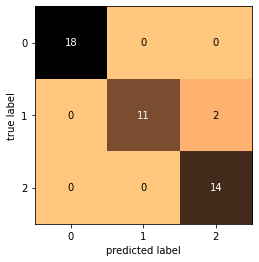

In [457]:
# Gerar a matrix de confusão NxN
conf_mat = confusion_matrix(y_test, y_predict_test)
plot_confusion_matrix(conf_mat,figsize=(12,4),cmap='copper_r')

In [458]:
#!pip install mlxtend --upgrade

[Text(0.5, 0.9, 'petal_length <= 2.45\nentropy = 1.582\nsamples = 105\nvalue = [32, 37, 36]\nclass = setosa'),
 Text(0.375, 0.7, 'entropy = 0.0\nsamples = 32\nvalue = [32, 0, 0]\nclass = setosa'),
 Text(0.625, 0.7, 'petal_width <= 1.75\nentropy = 1.0\nsamples = 73\nvalue = [0, 37, 36]\nclass = setosa'),
 Text(0.5, 0.5, 'petal_length <= 4.95\nentropy = 0.461\nsamples = 41\nvalue = [0, 37, 4]\nclass = setosa'),
 Text(0.25, 0.3, 'petal_width <= 1.65\nentropy = 0.179\nsamples = 37\nvalue = [0, 36, 1]\nclass = setosa'),
 Text(0.125, 0.1, 'entropy = 0.0\nsamples = 36\nvalue = [0, 36, 0]\nclass = setosa'),
 Text(0.375, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = setosa'),
 Text(0.75, 0.3, 'petal_width <= 1.65\nentropy = 0.811\nsamples = 4\nvalue = [0, 1, 3]\nclass = setosa'),
 Text(0.625, 0.1, 'entropy = 0.0\nsamples = 3\nvalue = [0, 0, 3]\nclass = setosa'),
 Text(0.875, 0.1, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = setosa'),
 Text(0.75, 0.5, 'entropy = 0.0\nsa

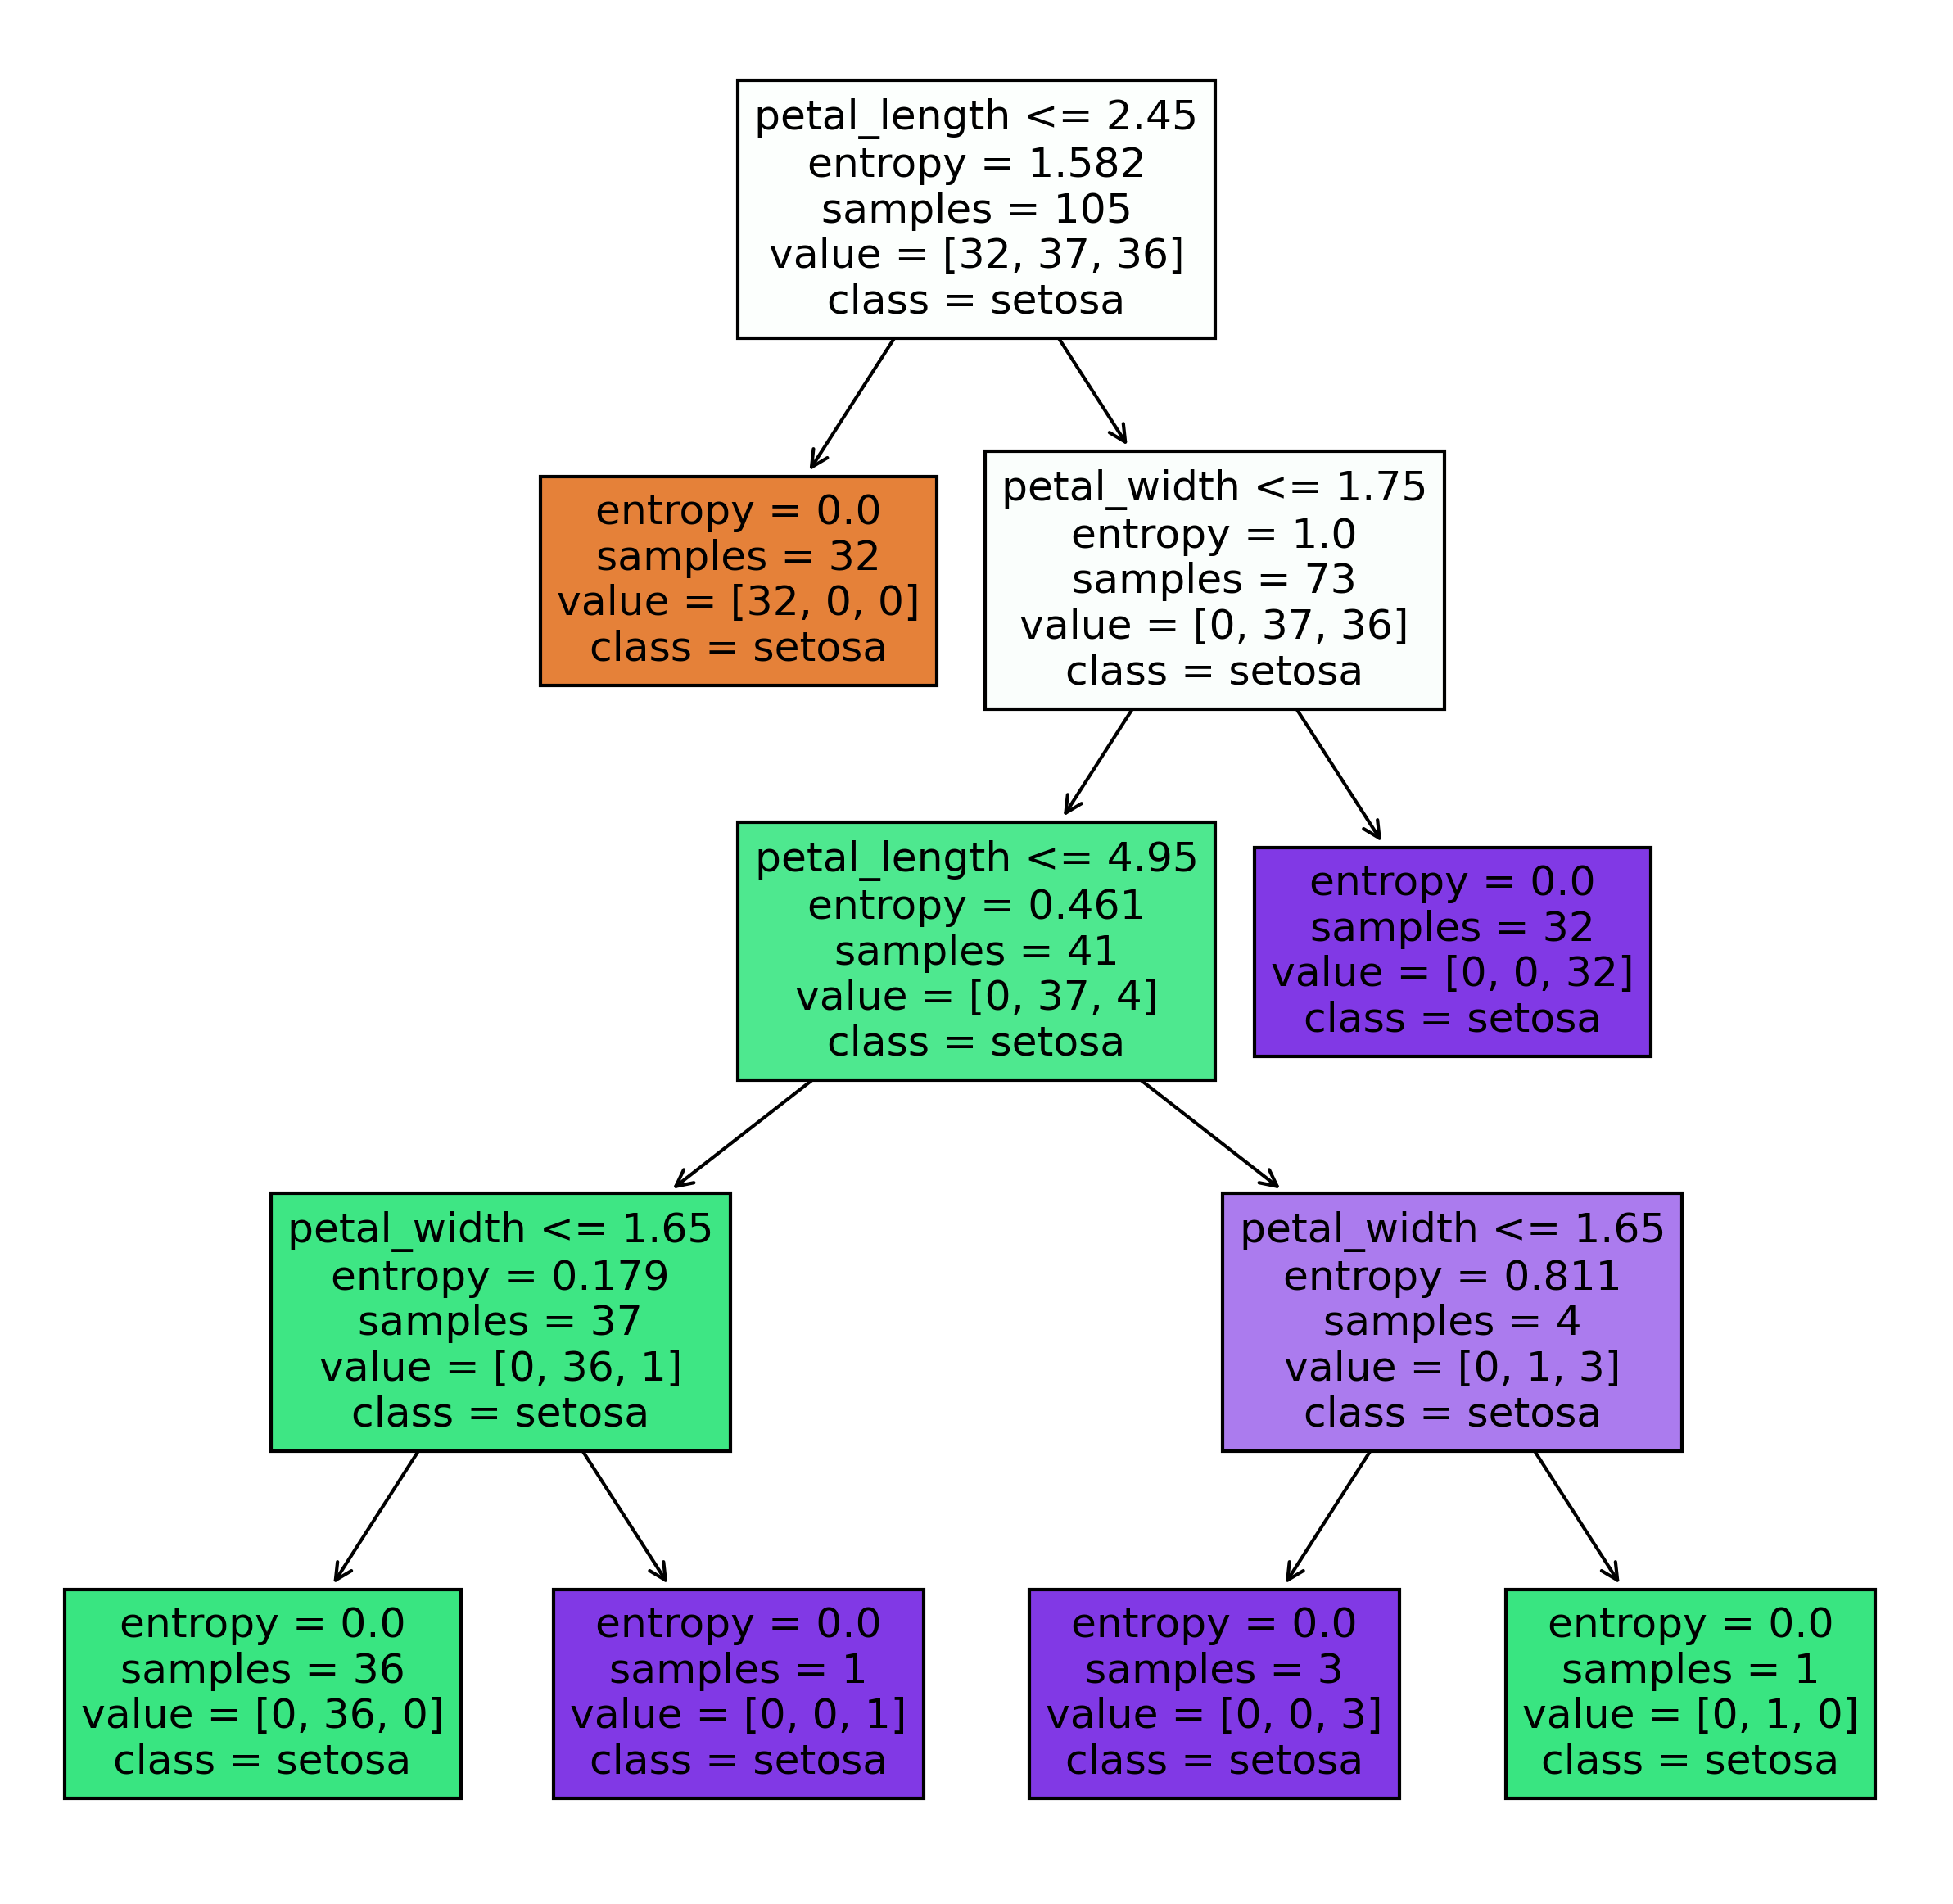

In [459]:
# Gerar a árvore para exibição

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(clf_dt,
               feature_names = df.columns, 
               #class_names=['a','b'],
               class_names=df.species,
               filled = True
               )
# fig.savefig('tree.png')


In [460]:
!pip install graphviz

In [461]:
import graphviz

In [462]:
dataset_model.columns.drop('species')

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

In [463]:
dot_data = tree.export_graphviz(clf_dt, out_file=None, 
                      feature_names=dataset_model.columns.drop('species'),  
                      class_names=df.species,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
# graph
graph.render(filename="iris", view=True, format='png')

'iris.png'

In [464]:
from sklearn.tree import export_text
r = export_text(clf_dt, feature_names=['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
print(r)

|--- Petal_Length <= 2.45
|   |--- class: 0
|--- Petal_Length >  2.45
|   |--- Petal_Width <= 1.75
|   |   |--- Petal_Length <= 4.95
|   |   |   |--- Petal_Width <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- Petal_Width >  1.65
|   |   |   |   |--- class: 2
|   |   |--- Petal_Length >  4.95
|   |   |   |--- Petal_Width <= 1.65
|   |   |   |   |--- class: 2
|   |   |   |--- Petal_Width >  1.65
|   |   |   |   |--- class: 1
|   |--- Petal_Width >  1.75
|   |   |--- class: 2



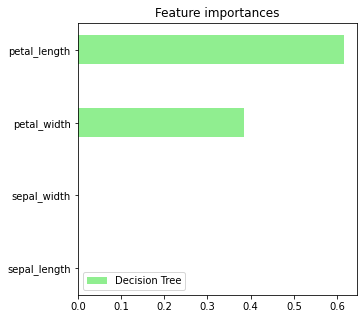

In [465]:
# Feature importances

feature_importance=pd.DataFrame({
    #'rfc':clf_rf.feature_importances_,
    'dt':clf_dt.feature_importances_
},index=dataset_model.drop(columns=['species']).columns)
feature_importance.sort_values(by='dt',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(5,5))
#rfc_feature=ax.barh(index,feature_importance['rfc'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)
ax.set_title("Feature importances")
ax.legend()
plt.show()
